In [1]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

### load the data

In [2]:
ad_file = '../../data/downloads/pbmc_ad.h5ad'
trained_model = '../../data/downloads/pbmc_model.h5'

In [3]:
os.makedirs("results", exist_ok=True)

# read h5ad file
ad = anndata.read_h5ad(ad_file)

# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights(trained_model)

2022-03-23 21:36:58.136480: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 21:36:58.136552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gpu-2-snapshot): /proc/driver/nvidia/version does not exist
2022-03-23 21:36:58.137198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### intercept vs. depth

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Pearson R: 0.982')

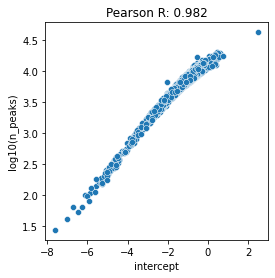

In [4]:
intercept = get_intercept(model) # get_intercept function
sc.pp.filter_cells(ad, min_counts=0)

f, ax = plt.subplots(figsize=(4,4))
r = scipy.stats.pearsonr(intercept, np.log10(ad.obs['n_genes']))[0]
sns.scatterplot(intercept, np.log10(ad.obs['n_genes']), ax=ax)
ax.set_xlabel('intercept')
ax.set_ylabel('log10(n_peaks)')
ax.set_title('Pearson R: %.3f'%r)
#f.savefig('results/intercept.pdf')

### cell embeddings

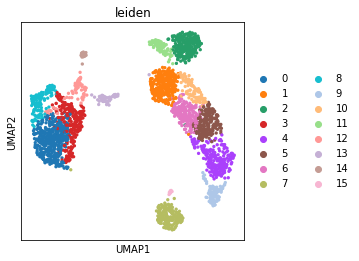

In [5]:
proj = get_cell_embedding(model) # get_cell_embedding function
pd.DataFrame(proj).to_csv('results/projection_atac.csv')

f, ax = plt.subplots(figsize=(4, 4))
ad.obsm['projection'] = pd.read_csv('results/projection_atac.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color='leiden', ax=ax)

### imputation

In [9]:
# since imputation generates a dense cell by peak matrix as output.
# it won't scale to very large dataset due to memory issue.

all_seqs = 'processed/all_seqs.h5' # from the preprocess step

# make tesorflow dataset to feed into model
m = ad.X.tocoo().transpose().tocsr()
n_cells = ad.shape[0]
all_ds = tf.data.Dataset.from_generator(
    generator(all_seqs, m), 
    output_signature=(
            tf.TensorSpec(shape=(1344,4), dtype=tf.int8),
            tf.TensorSpec(shape=(n_cells), dtype=tf.int8),
    )
).batch(128).prefetch(tf.data.AUTOTUNE)
 
Y_impute = imputation_Y_normalize(all_ds, model)